## Modeling Notebook

In [33]:
import pandas as pd
import yfinance as yf
from yahooquery import Ticker
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

In [2]:
# Reading in Data from EDA Notebook
stock_data = pd.read_csv('data/analyst_data_with_labels.csv')
stock_data.head()

,Ticker,AveragePriceTarget,NumRatings,ClosingPrice,MarketCap,ExpectedGrowthRate,OverallRecommendation,ProjectedMarketCap
0,A,166.50,14,138.09,4.088458e+10,0.206,0,4.930681e+10
1,AA,50.00,11,39.43,7.032538e+09,0.268,1,8.917258e+09
2,AADI,37.00,3,7.20,1.756447e+08,4.139,1,9.026382e+08
3,AAL,16.62,14,13.89,1.862496e+10,0.197,0,2.229408e+10
4,AAN,16.00,5,9.54,2.936460e+08,0.677,1,4.924443e+08


In [3]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3261 entries, 0 to 3260
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Ticker                 3261 non-null   object 
 1   AveragePriceTarget     3261 non-null   float64
 2   NumRatings             3261 non-null   int64  
 3   ClosingPrice           3261 non-null   float64
 4   MarketCap              3261 non-null   float64
 5   ExpectedGrowthRate     3261 non-null   float64
 6   OverallRecommendation  3261 non-null   int64  
 7   ProjectedMarketCap     3261 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 203.9+ KB


In [4]:
# Dropping Bad Columns
stock_data.drop(stock_data[stock_data['Ticker'] == 'STR'].index, axis = 0, inplace = True)
stock_data.drop(stock_data[stock_data['Ticker'] == 'BIOS'].index, axis = 0, inplace = True)

#### First Basic Model- Use Normalized EBITDA

Normalized EBITDA is good because it measures the profitability of businesses. It isn't the end-all-be-all, especially with smaller, more speculative companies (mainly in the biotech industry), but it is a good starting point.

In [5]:
# Using YahooQuery to get Normalized EBITDA for each ticker
for ticker in tqdm(stock_data['Ticker']):
    # Create new column -> Append most recent Normalized EBITDA number
    stock_data['NormEBITDA'] = Ticker(ticker).income_statement()['NormalizedEBITDA'][-1]

  0%|          | 8/3259 [00:05<34:30,  1.57it/s]


KeyError: 'NormalizedEBITDA'

In [ ]:
Ticker(stock_data['Ticker'][8]).all_financial_data()

,asOfDate,periodType,currencyCode,AverageDilutionEarnings,BasicAverageShares,BasicEPS,BeginningCashPosition,CapitalStock,CashDividendsPaid,ChangeInCashSupplementalAsReported,...,ShareIssued,StockholdersEquity,TangibleBookValue,TaxEffectOfUnusualItems,TaxProvision,TaxRateForCalcs,TotalAssets,TotalEquityGrossMinorityInterest,TotalLiabilitiesNetMinorityInterest,TotalRevenue
symbol,,,,,,,,,,,,,,,,,,,,,
AB,2019-12-31,12M,USD,79000.0,95883604.0,2.488048,0.0,1.620602e+09,-222485000.0,0.0,...,98092098.0,1.552538e+09,1.552538e+09,0.0,27729000.0,0.051,1.554264e+09,1.552538e+09,1726000.0,266292000.0
AB,2020-12-31,12M,USD,NaN,96870007.0,2.884071,0.0,1.658226e+09,-270881000.0,0.0,...,98222942.0,1.604157e+09,1.604157e+09,0.0,29024000.0,0.050,1.606033e+09,1.604157e+09,1876000.0,308404000.0
AB,2021-12-31,12M,USD,NaN,99545000.0,3.880000,0.0,1.697638e+09,-357455000.0,0.0,...,99271727.0,1.621624e+09,1.621624e+09,0.0,30483000.0,0.052,1.623764e+09,1.621624e+09,2140000.0,416326000.0
AB,2022-12-31,12M,USD,2000.0,NaN,NaN,0.0,2.161562e+09,-361024000.0,0.0,...,113801097.0,2.073003e+09,2.073003e+09,0.0,31339000.0,0.049,2.074626e+09,2.073003e+09,1623000.0,305504000.0


In [6]:
stock_data.drop(columns = ['NormEBITDA'], axis = 1, inplace = True)

Looks like some companies don't have Normalized EBITDA as a metric, which doesn't really make sense, but alas. Let's use a more basic metric, TotalRevenue, to measure instead

In [7]:
error_tickers = []

In [8]:
total_revenue = []
for ticker in tqdm(stock_data['Ticker']):
    try:
        revenue = Ticker(ticker).all_financial_data()['TotalRevenue'][-1]
        total_revenue.append(revenue)
    except:
        total_revenue.append(None)
        error_tickers.append(ticker)

# Create a pandas series from the total revenue data
total_revenue_series = pd.Series(total_revenue, index=stock_data.index)

# Add the new 'TotalRevenue' column to the stock_data dataframe
stock_data['TotalRevenue'] = total_revenue_series

100%|██████████| 3259/3259 [39:56<00:00,  1.36it/s] 


In [16]:
error_tickers

['SAR', 'ZYME']

In [17]:
len(error_tickers)

2

In [19]:
mask = ~stock_data['Ticker'].isin(error_tickers)

# New DataFrame with tickers dropped
stock_data = stock_data[mask]

In [21]:
total_revenue_series

0       6.848000e+09
1       1.245100e+10
2       1.000000e+06
3       4.897100e+10
4       2.249434e+09
            ...     
3256    1.631810e+08
3257    1.045800e+07
3258    1.281800e+09
3259             NaN
3260    1.303010e+08
Length: 3259, dtype: float64

In [20]:
stock_data['TotalRevenue'] = total_revenue_series

C:\Users\cnade\AppData\Local\Temp\ipykernel_80500\4240918470.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['TotalRevenue'] = total_revenue_series


In [25]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3257 entries, 0 to 3260
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Ticker                 3257 non-null   object 
 1   AveragePriceTarget     3257 non-null   float64
 2   NumRatings             3257 non-null   int64  
 3   ClosingPrice           3257 non-null   float64
 4   MarketCap              3257 non-null   float64
 5   ExpectedGrowthRate     3257 non-null   float64
 6   OverallRecommendation  3257 non-null   int64  
 7   ProjectedMarketCap     3257 non-null   float64
 8   TotalRevenue           3230 non-null   float64
dtypes: float64(6), int64(2), object(1)
memory usage: 254.5+ KB


In [26]:
stock_data.dropna(inplace= True)

C:\Users\cnade\AppData\Local\Temp\ipykernel_80500\3893329783.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data.dropna(inplace= True)


In [27]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3230 entries, 0 to 3260
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Ticker                 3230 non-null   object 
 1   AveragePriceTarget     3230 non-null   float64
 2   NumRatings             3230 non-null   int64  
 3   ClosingPrice           3230 non-null   float64
 4   MarketCap              3230 non-null   float64
 5   ExpectedGrowthRate     3230 non-null   float64
 6   OverallRecommendation  3230 non-null   int64  
 7   ProjectedMarketCap     3230 non-null   float64
 8   TotalRevenue           3230 non-null   float64
dtypes: float64(6), int64(2), object(1)
memory usage: 252.3+ KB


Nice- All our companies reported some sort of revenue (As required by law). We're now ready to set up our first model

In [28]:
stock_data.to_csv('First_Model_Data.csv')

In [29]:
stock_data.describe()

,AveragePriceTarget,NumRatings,ClosingPrice,MarketCap,ExpectedGrowthRate,OverallRecommendation,ProjectedMarketCap,TotalRevenue
count,3230.000000,3230.000000,3230.000000,3.230000e+03,3230.000000,3230.000000,3.230000e+03,3.230000e+03
mean,65.905913,8.595666,54.505889,1.599859e+10,1.050058,0.520124,1.866133e+10,8.406432e+10
std,159.714747,5.059875,148.724780,8.129981e+10,4.222461,0.591619,9.105191e+10,2.898617e+12
min,0.500000,3.000000,0.060000,1.928435e+06,-0.658000,-1.000000,1.355883e+07,-1.116000e+09
25%,12.000000,4.000000,6.680000,4.824180e+08,0.140250,0.000000,8.893442e+08,1.674785e+08
50%,28.000000,7.000000,20.235000,2.086045e+09,0.305000,1.000000,2.839494e+09,1.007052e+09
75%,71.000000,12.000000,58.110000,7.629272e+09,0.724000,1.000000,9.410879e+09,4.827174e+09
max,5712.500000,20.000000,5542.840000,2.593336e+12,149.000000,1.000000,2.738563e+12,1.594740e+14


In [30]:
first_model_df = stock_data[['Ticker', 'TotalRevenue','OverallRecommendation']]
first_model_df.set_index('Ticker', inplace = True)

In [47]:
X = first_model_df['TotalRevenue']
y = first_model_df['OverallRecommendation']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.4, random_state= 42)

In [48]:
X_train = X_train.to_numpy().reshape(-1, 1)
X_test = X_test.to_numpy().reshape(-1, 1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

0.5727554179566563


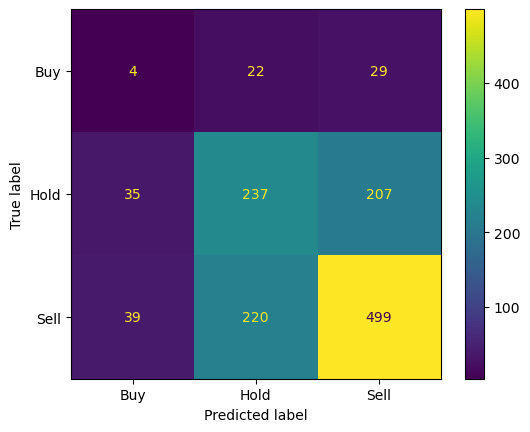

In [55]:
rfc = RandomForestClassifier(random_state= 42)
rfc.fit(X_train_scaled, y_train)
y_pred = rfc.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
cm = confusion_matrix(y_true = y_test, y_pred = y_pred)
ConfusionMatrixDisplay(cm, display_labels= ['Buy','Hold','Sell']).plot()